# Test pytorch optimizers

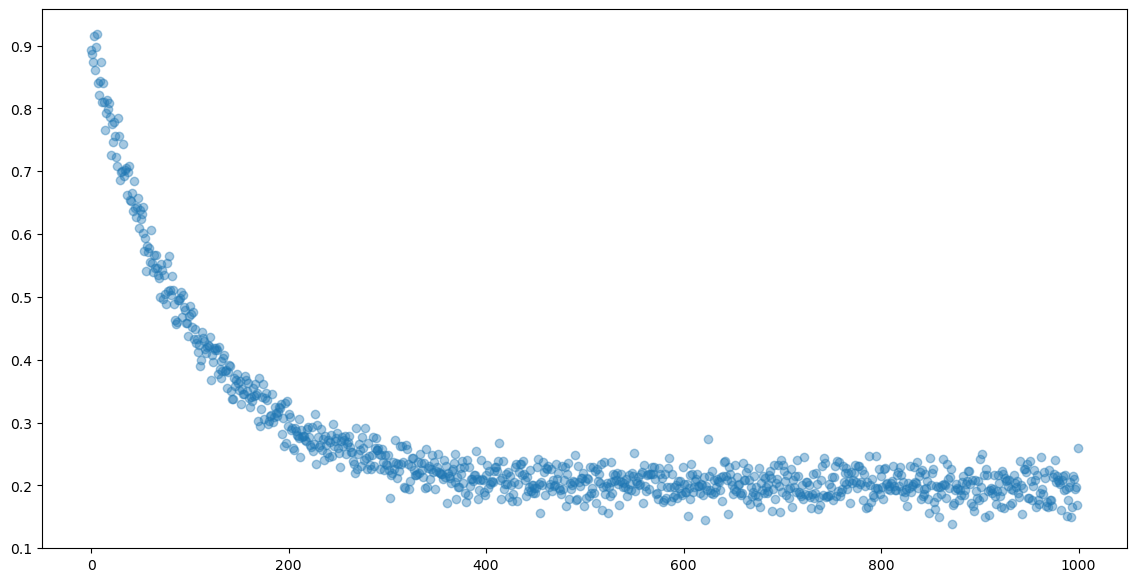

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.functional import F
from copy import copy

n = 1000
noise = torch.Tensor(np.random.normal(0, 0.02, size=n))
x = torch.arange(n)
a, k, b = 0.7, .01, 0.2
y = a * np.exp(-k * x) + b + noise
plt.figure(figsize=(14, 7))
plt.scatter(x, y, alpha=0.4)

In [12]:
class Model(nn.Module):
    """
    Custom Pytorch model for gradient optimization.
    """

    def __init__(self):

        super().__init__()
        # initialize weights with random numbers
        weights = torch.distributions.Uniform(0, 0.1).sample((3,))
        # make weights torch parameters
        self.weights = nn.Parameter(weights)

    def forward(self, X):
        """
        Implement function to be optimised. In this case, an exponential decay
        function (a + exp(-k * X) + b),
        """
        a, k, b = self.weights
        return a * torch.exp(-k * X) + b


def training_loop(model, optimizer, n=1000):
    "Training loop for torch model."
    losses = []
    for i in range(n):
        preds = model(x)
        loss = F.mse_loss(preds, y).sqrt()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.detach().numpy())
    return losses


Parameter containing:
tensor([0.6772, 0.0097, 0.2002], requires_grad=True)


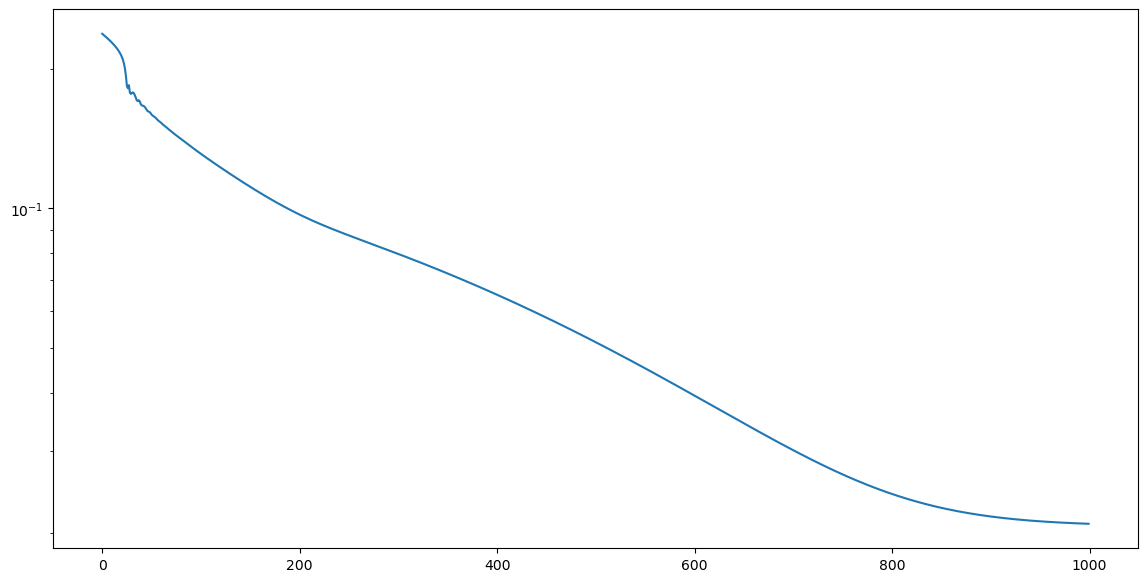

In [14]:
# instantiate model
m = Model()
# Instantiate optimizer
opt = torch.optim.Adam(m.parameters(), lr=0.001)
losses = training_loop(m, opt)
plt.figure(figsize=(14, 7))
plt.plot(losses)
plt.yscale("log")
print(m.weights)